# Part 2. Segmentation

This a a second part of the project, first part of which has been handled in the 1_data_analysis_and_cleaning file. Here, we will reduce the dimentionality of the dataset as well as create clusters to find out the most prospective target for the mailing campaign.

### PCA

Often, when constructing a customer segmentation framework, it's imperative to ascertain a particular level of clarity so that business stakeholders can easily understand the division and marketing teams can create personas. In this instance, however, the ultimate goal of segmentation is the task at hand - prediction for the mailing campaign. This, combined with the muli-dimension dataset means that will perform dimensionality reduction using the PCA method.


This, combined with the multi-dimension dataset convinced us to perform dimensionality reduction using the PCA method.

In [1]:
# import misc libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import ML libraries
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
customers = pd.read_csv('dataset/customers_clean.csv')
azdias = pd.read_csv('dataset/azdias_clean.csv')

In [3]:
azdias.head()

,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KONSUMZELLE,is_osten,SOHO_KZ,UNGLEICHENN_FLAG,ANREDE_KZ,CAMEO_INTL_2015_dummy_12.0,CAMEO_INTL_2015_dummy_13.0,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
0,1.0,0,0.0,1.0,1.0,1.0,1.0,2,0,0,...,-0.387156,1.363963,0.684573,1.056015,1.456923,-5.717081e-01,0.548477,-0.027165,1.138410,-1.683646
1,1.0,1,0.0,0.0,1.0,0.0,0.0,2,0,0,...,-0.387156,-0.363880,1.034748,0.442084,0.020864,-5.717081e-01,0.548477,-1.085200,1.138410,0.164528
2,1.0,0,0.0,0.0,1.0,0.0,0.0,2,1,0,...,0.480524,-2.091723,0.334399,0.749049,1.815938,4.791145e-16,0.548477,1.559887,-0.286034,1.088616
3,1.0,0,0.0,0.0,1.0,0.0,0.0,1,0,0,...,-0.387156,-0.363880,-1.066298,-0.785778,-0.697165,-1.111143e+00,0.548477,-0.556183,0.426188,0.164528
4,1.0,0,0.0,0.0,1.0,0.0,0.0,2,0,0,...,-0.387156,-0.363880,1.384922,-0.171847,-0.697165,1.046597e+00,0.548477,1.559887,0.426188,-1.683646


Start with fittin PCA on the dataset.

In [4]:
pca = PCA()
pca.fit(azdias)

PCA()

In [5]:
# get the incremental variance explained
explained_variance = np.cumsum(pca.explained_variance_ratio_)

With that, we can decide on how many components to keep based on variance incrementally exaplained with more components. 

After fitting PCA on the dataset we plot the cumulative variance explained by including more components to decide how many of them we need.

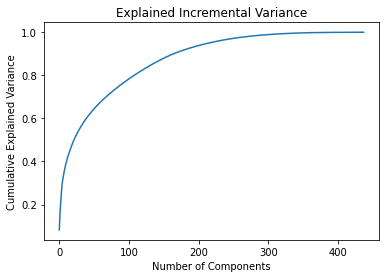

In [6]:
plt.plot(explained_variance)
plt.title('Explained Incremental Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()

In [7]:
print(f'Out of {azdias.shape[1]} features, {sum(explained_variance < .9)} components explain 90% of variance in the dataset')

Out of 438 features, 165 components explain 90% of variance in the dataset


In [8]:
print(f'Top 3 components explain {explained_variance[2]:.1%} of variability')

Top 3 components explain 20.8% of variability


Knowing that, we can decide on keeping top 90% components and reapplying PCA with this parameter.

In [9]:
n_components = sum(explained_variance < .9)
pca = PCA(n_components=n_components)
azdias_pca = pca.fit_transform(azdias)

In [11]:
def plot_component_weights(pca, component, cols, n=3):
    '''
    Plots top and bottom n  for a given PCA component.
    
    INPUT:
     - pca (PCA object): PCA object
     - component (int): the component index
     - cols (columns of the ): a list of column names from the dataframe before fitting PCA
     - n (int): number of top and bottom items to plot
     
    OUTPUT:
     - None
    '''
    # get top and bottom n weights for a given component
    top = pd.DataFrame(pca.components_[component], index=cols, columns=['weight']).sort_values(by='weight').head(n)
    bottom = pd.DataFrame(pca.components_[component], index=cols, columns=['weight']).sort_values(by='weight').tail(n)
    df = pd.concat([top, bottom], axis=0)
    
    # plot the results
    plt.barh(df.index, df['weight'])
    plt.show()
    
    return None

The first component (explaining 10% of variance) is mostly determined by the car person owns (KBA) and economic (LP_STATUS_GROB) and social (LP_STATUS_FEIN) status. The car is an interesting addition but we may assume that the car owned by a person is correlated with income. After all, socioeconomic factors are usually the leading factors for market segmentation. Similarly, MOBI_REGIO, which indicates mobility, should be correlated with car usage.

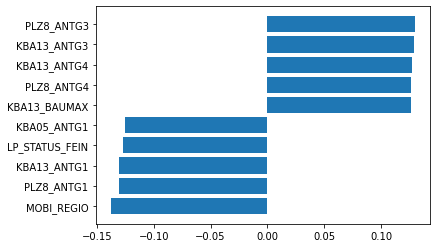

In [12]:
plot_component_weights(pca, 0, azdias.columns, n=5)

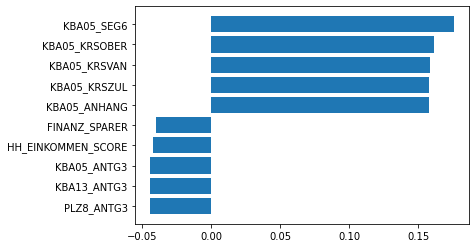

In [13]:
plot_component_weights(pca, 1, azdias.columns, n=5)

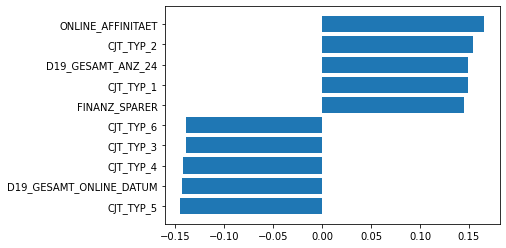

In [14]:
plot_component_weights(pca, 2, azdias.columns, n=5)

### K-means clustering

K-means clustering is an unsupervised ML algorithm which makes it perfect when we don't exactly know what clusters data points should end up in. It's by far the most popular algorithm for unsupervised clustering problems. It’s also proper when following the MECE rule (mutually exclusive - collectively exhaustive) which means that each customer needs to belong to exactly one segment. If, on the other hand, we would like to try to make customers fit to many different segments, we could use the Hidden Markov Model (HMM).

Alternatively, we could also use Agglomerative Hierarchical Clustering which iteratively merges clusters by their similarity, starting with each data point being its own cluster. Its advantages are that it provides granular information on any data point and it is not sensitive to outliers, which gives it a great descriptive utility. We might not want to do it here though cause it's slow and not optimal for predicting on new instances.

Let's stick to K-means clustering.

In order to decide on how many clusters we even want, we need to employ the elbow method. It involves plotting the explained variation as a function of the number of clusters and picking the elbow of the curve to spot the sweet spot between relatively low numbers of clusters which make the biggest difference. The function measures drop in inertia, being a measure of how internally coherent clusters are. The inertia formula quantifies how close the data points are to their centroid. The lower the value, the denser the cluster.

In [15]:
# check number of clusters for elbow method
sse = []
params = [x for x in range(1, 45)]

for i in params:
    km = KMeans(n_clusters=i, n_init=10)
    km.fit(azdias_pca[:25000])
    sse.append(km.inertia_)
    print(f'Done {i} out of {len(params)}.') if i % 10 == 0 else None
    print(f'Done all.') if i == len(params) else None


Done 10 out of 44.
Done 20 out of 44.
Done 30 out of 44.
Done 40 out of 44.
Done all.


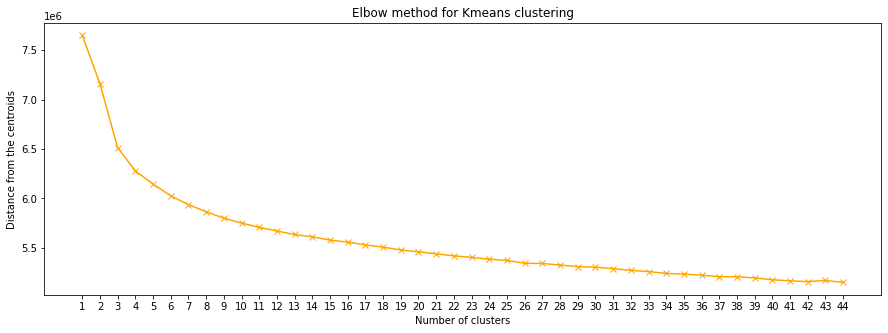

In [19]:
# print elbow chart
plt.figure(figsize=(15,5))
plt.plot(params, sse, linestyle= "-",marker = "x", color="orange")
plt.title('Elbow method for Kmeans clustering')
plt.ylabel('Distance from the centroids')
plt.xlabel('Number of clusters')
plt.xticks(params)
plt.show()

We see a sharp decline around 6 clusters and then a steady downward slope. In my opinion selecting the proper number of clusters might be more of an art than science depending on the business needs. After careful consideration, I’ve decided to go with 11 clusters.

In [20]:
n_clusters = 11

In [25]:
# create a Pipeline object
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('cluster', KMeans(n_clusters=n_clusters, n_init=10))
])

In [26]:
# Fit the pipeline on the general German population
pipeline.fit(azdias)
azdias_clustered = pd.DataFrame(pipeline.predict(azdias), columns=['cluster'])

In [27]:
azdias_clustered.head()

,cluster
0,1
1,1
2,5
3,0
4,5


In [28]:
# Fit the pipeline on the customers dataset
customers = pd.read_csv('dataset/customers_clean.csv')
customers_clean = customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
customers_clean = customers_clean[azdias.columns]      # make sure columns are identically ordered 
customers_clustered = pd.DataFrame(pipeline.predict(customers_clean), columns=['cluster'])

In [33]:
# pickle clusters for later use
azdias_clustered.to_pickle('dataset/azdias_clustered.pkl')
customers_clustered.to_pickle('dataset/customers_clustered.pkl')

In [35]:
azdias_clustered.head()

,cluster
0,1
1,1
2,5
3,0
4,5


It's time to check how the general population differs from customers in terms of clusters. We know that any company's customers are already a specific sub-group of general population and there is selection bias so these two datasets should show significance difference.

In [36]:
# compare segments between the general population and customer base 
azdias_agg = azdias_clustered['cluster'].value_counts().sort_values(ascending=False)
customer_agg = customers_clustered['cluster'].value_counts().sort_values(ascending=False)

In [37]:
azdias_agg.values

array([106447,  99782,  89546,  79209,  77290,  71396,  58836,  53407,
        49118,  44188,  13928], dtype=int64)

In [38]:
populations = pd.DataFrame(azdias_agg).rename(columns={'cluster': 'Germany'})
populations = pd.concat([customer_agg, azdias_agg], axis=1).fillna(0).sort_index()
populations.columns = ['customers', 'germany']
populations

,customers,germany
0,96680.0,58836
1,64067.0,106447
2,466.0,13928
3,28475.0,44188
4,0.0,71396
5,0.0,99782
6,1964.0,77290
7,0.0,79209
8,0.0,53407
9,0.0,89546


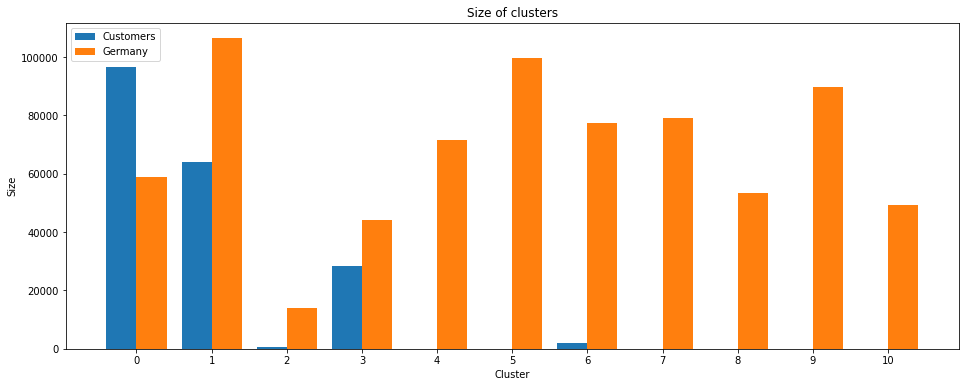

In [39]:

fig, ax = plt.subplots(figsize=(16,6))
x = np.arange(n_clusters)

ax1 = ax.bar(x - 0.2, populations['customers'], width=.4)
ax2 = ax.bar(x + 0.2, populations['germany'], width=.4)

plt.title('Size of clusters')
plt.ylabel('Size')
plt.xlabel('Cluster')
plt.legend(['Customers', 'Germany'], loc='upper left')
plt.xticks(x)
plt.show()


In [40]:
# get ids of most important centers in the given cluster
centers = pipeline['cluster'].cluster_centers_[0]    # get all the centers for the most important cluster
ids = np.argsort(centers)[::-1]             # get ids of centers sorted (no ascending argument in argsort, hence slicing)
top_ids = ids[:3]                           # select top 3 components
print(f'The cluster #0 is mostly influenced by components: {list(top_ids)}')

The cluster #0 is mostly influenced by components: [2, 9, 4]


Looking at the most overrepresented cluster (the most prevalent customer group), we see a positive impact of customer journey types 1 and 2 - traditionalists and minimalists. This is in line with the order-mail company being somewhat of a traditional business model. These customers also tend to be less interested in saving money (indicated by the FRANZ_SPARER feature).

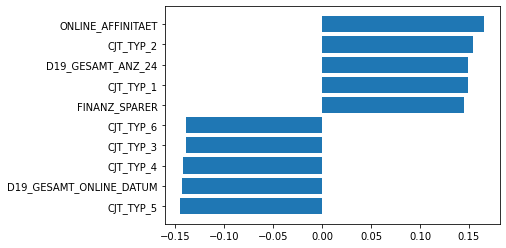

In [41]:
# get top and bottom features for the given component by weights
plot_component_weights(pipeline['pca'], top_ids[0], azdias.columns, n=5)

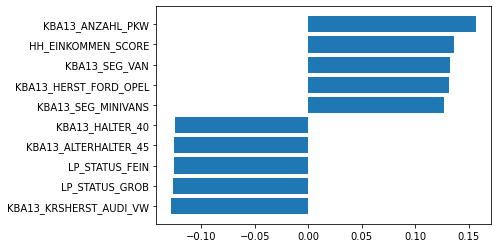

In [42]:
# get top and bottom features for the given component by weights
plot_component_weights(pipeline['pca'], top_ids[1], azdias.columns, n=5)

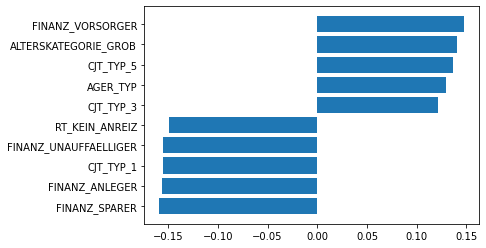

In [43]:
# get top and bottom features for the given component by weights
plot_component_weights(pipeline['pca'], top_ids[2], azdias.columns, n=5)